# Ship Detection U-Net in PyTorch

In [ ]:
import os

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.measure import label, regionprops
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.rcParams['font.family'] = 'Times New Roman'

# Load data

In [2]:
train_segmentations = pd.read_csv('train_ship_segmentations_v2.csv')
sample_submission = pd.read_csv('sample_submission_v2.csv')

train_v2_path = 'train_v2'

# EDA

In [3]:
print(f'train samples - {train_segmentations.shape[0]}')
train_segmentations.head()

train samples - 231723


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


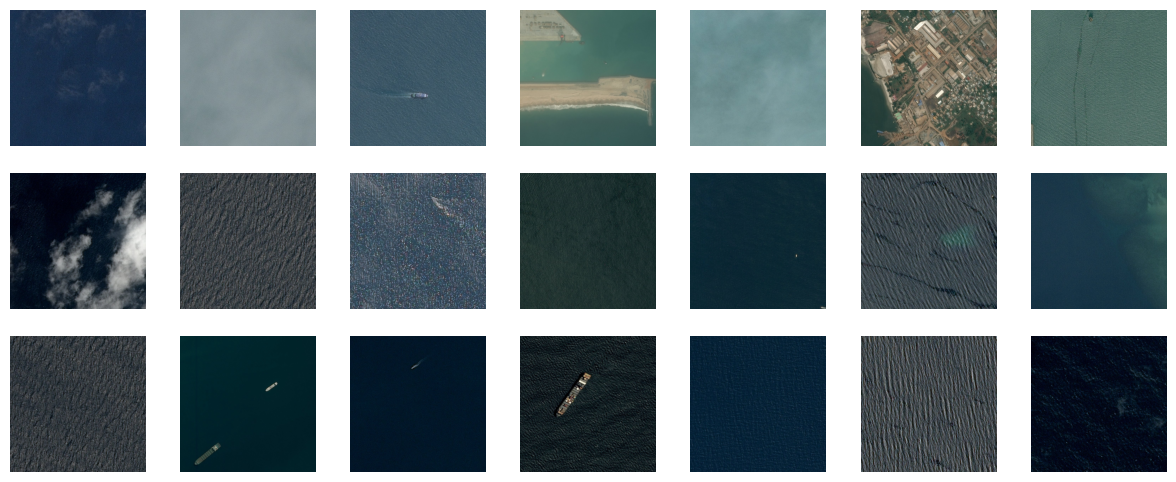

In [5]:
def display_images(folder_path, num_images=10, num_columns=5):
    # Get a list of all files in the folder
    image_files = [f for f in os.listdir(folder_path)[:num_images]]

    # Calculate the number of rows needed
    num_rows = (num_images + num_columns - 1) // num_columns

    # Display the images in a grid
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 6))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = imread(img_path)
        row_index, col_index = divmod(i, num_columns)
        axes[row_index, col_index].imshow(img)
        axes[row_index, col_index].axis('off')

    plt.show()

display_images(train_v2_path, num_images=21, num_columns=7)

# RLE

In [6]:
def rle_encode(img):
    """
    Encode a binary mask represented as a 2D numpy array using Run-Length Encoding (RLE).

    Parameters:
    - img (numpy.ndarray): A 2D binary array representing the mask.

    Returns:
    - str: The RLE-encoded string representing the binary mask.
    """

    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(mask_rle, shape=(768, 768)):
    """
    Decode a Run-Length Encoded (RLE) binary mask into a 2D numpy array.

    Parameters:
    - mask_rle (str): The RLE-encoded string representing the binary mask.
    - shape (tuple, optional): The shape of the target 2D array. Default is (768, 768).

    Returns:
    - torch.Tensor: A 2D binary tensor representing the decoded mask.
    """

    if type(mask_rle) != str:
        return torch.zeros(shape, dtype=torch.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    # Convert to PyTorch tensor and reshape
    return torch.tensor(img.reshape(shape).T, dtype=torch.uint8)  # Needed to align to RLE direction


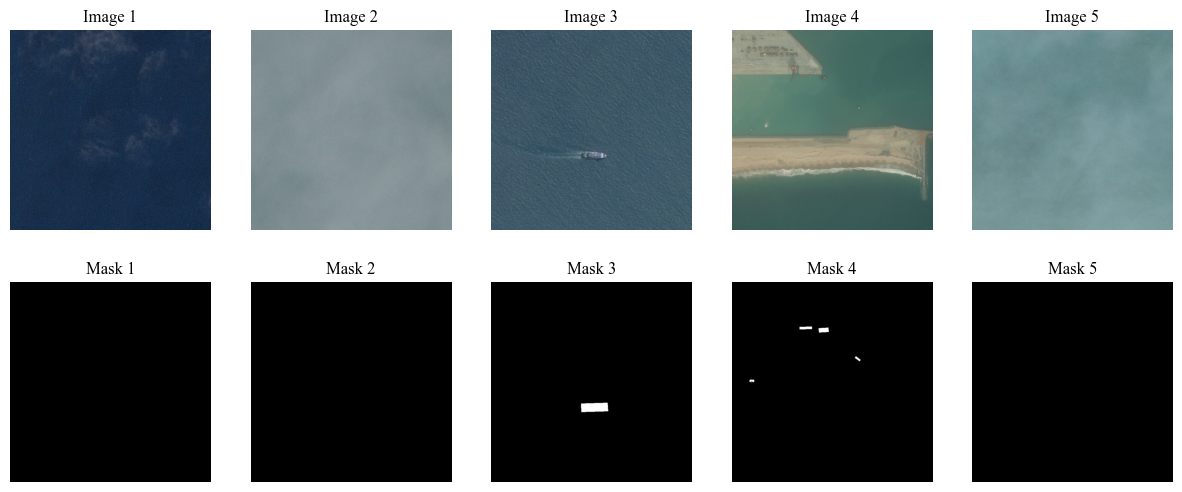

In [7]:
def display_masks(folder_path, csv_file, num_images=5):
    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path)[:num_images]]

    # Display images and masks in a 2-row grid
    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for i in range(num_images):
        img_path = os.path.join(folder_path, image_files[i])
        img = imread(img_path)

        # Initialize the mask as a blank array
        mask = np.zeros((768, 768), dtype=np.uint8)

        # Retrieve all masks associated with the image and decode them
        all_masks = csv_file[csv_file['ImageId'] == image_files[i]].EncodedPixels
        for m in all_masks:
            if isinstance(m, str):  # Only decode if `m` is a valid RLE string
                decoded_mask = rle_decode(m, shape=(768, 768))
                mask = np.maximum(mask, decoded_mask)  # Combine masks using maximum

        # Plot the original image
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Image {i+1}")

        # Plot the mask
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Mask {i+1}")

    plt.show()

# Example usage
display_masks(train_v2_path, csv_file=train_segmentations, num_images=5)


### Images without ships

In [8]:
images_with_ships = train_segmentations[train_segmentations.EncodedPixels.notna()].ImageId.nunique()
images_without_ships = train_segmentations[train_segmentations.EncodedPixels.isna()].ImageId.nunique()

print(f'Number of images with ships    - {images_with_ships}  | {round(images_with_ships / train_segmentations.ImageId.nunique() * 100)}%')
print(f'Number of images without ships - {images_without_ships} | {round(images_without_ships / train_segmentations.ImageId.nunique() * 100)}%')

Number of images with ships    - 42556  | 22%
Number of images without ships - 150000 | 78%


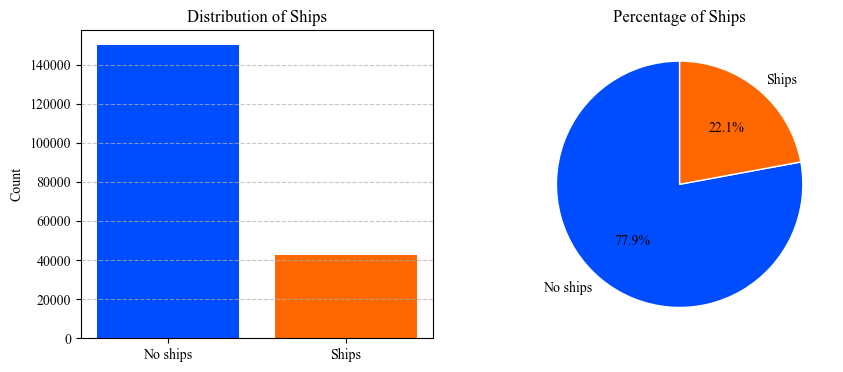

In [9]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot bar chart
axes[0].bar(['No ships', 'Ships'], [images_without_ships, images_with_ships], color=plt.cm.jet([0.2, 0.8]))
axes[0].set_title('Distribution of Ships')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot pie chart
axes[1].pie([images_without_ships, images_with_ships], labels=['No ships', 'Ships'], autopct='%1.1f%%',
            startangle=90, colors=plt.cm.jet([0.2, 0.8]), wedgeprops={"linewidth": 1, "edgecolor": "white"})
axes[1].set_title('Percentage of Ships')
axes[1].set_aspect('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

# Display the plot
plt.show()

### Number of Ships Distribution

In [10]:
n_ships_df = train_segmentations.dropna().groupby('ImageId').count()
n_ships_df.rename({'EncodedPixels': 'n_ships'}, axis='columns', inplace=True)

n_ships_df.describe()

,n_ships
count,42556.000000
mean,1.920364
std,1.906073
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,15.000000


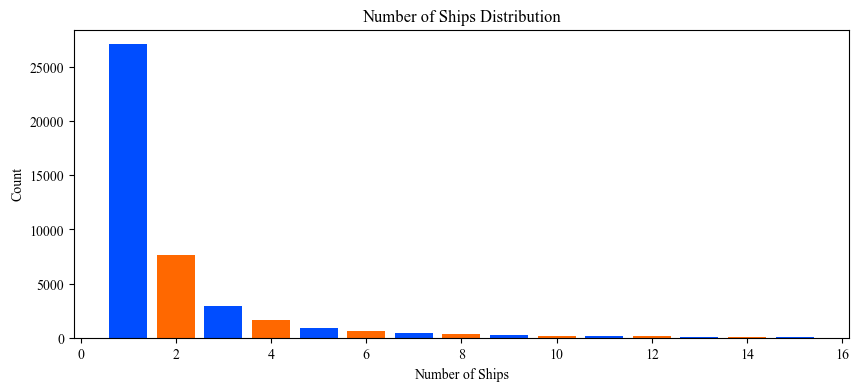

In [12]:
plt.figure(figsize=(10, 4))
plt.title('Number of Ships Distribution')
plt.xlabel('Number of Ships')
plt.ylabel('Count')
plt.bar(range(1, 16), n_ships_df.n_ships.value_counts(), color=plt.cm.jet([0.2, 0.8]));

In [13]:
n_ships_df.n_ships.value_counts()

1     27104
2      7674
3      2954
4      1622
5       925
6       657
7       406
8       318
9       243
10      168
11      144
12      124
14       76
13       75
15       66
Name: n_ships, dtype: int64

# Preparing Train and Validation Data

In [16]:
def split_data(data:pd.DataFrame, empty_masks=2000, test_size=0.3, random_state=42): # type: ignore
    """
    Split the data into training and testing sets.

    Parameters:
    - data (DataFrame): The input DataFrame containing the dataset.
    - empty_masks (int, optional): The number of images with empty masks. Defaults to 2000.
    - test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.3.
    - random_state (int, optional): Seed for random number generation to ensure reproducibility. Defaults to 42.

    Returns: The training and testing sets.
    """
    masks_df = data.copy()
    masks_df['ship'] = masks_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
    masks_df['n_ships'] = masks_df.groupby('ImageId')['ship'].transform('sum')
    masks_df.drop_duplicates(subset='ImageId', keep='first', inplace=True)

    # Keep only n empty masks
    empty_masks_df = masks_df[masks_df.ship == 0]
    masks_df = masks_df[masks_df.ship == 1]
    masks_df = pd.concat([masks_df, empty_masks_df.sample(n=empty_masks, random_state=random_state)], axis=0)

    train_ids, test_ids = train_test_split(
        masks_df, test_size=test_size, stratify=masks_df['n_ships'].values, random_state=random_state
    )

    train_data = data[data['ImageId'].isin(train_ids.ImageId)]
    test_data = data[data['ImageId'].isin(test_ids.ImageId)]

    return train_data, test_data

# CustomDataGenerator

In [ ]:
class ShipsData(Dataset):
    def __init__(self, image_folder, csv_file, image_size=(768, 768), transform=None):
        self.image_folder = image_folder
        self.image_size = image_size
        self.data = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = os.path.join(self.image_folder, row['ImageId'])

        # Load image
        img = cv2.imread(image_path)
        img = cv2.resize(img, self.image_size)
        img = img / 255.0  # Normalize
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # Convert to tensor and adjust dimensions

        # Decode RLE to mask
        all_masks = self.data[self.data['ImageId'] == row['ImageId']].EncodedPixels
        mask = np.zeros(self.image_size, dtype=np.uint8)
        for m in all_masks:
            if isinstance(m, str):  # Only decode if `m` is a valid RLE string
                decoded_mask = rle_decode(m, shape=self.image_size)
                mask = np.maximum(mask, decoded_mask)  # Combine using maximum to avoid errors

        # Clip the mask values to ensure binary values and convert to tensor
        mask = np.clip(mask, 0, 1)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add channel dimension

        if self.transform:
            img = self.transform(img)

        return img, mask


In [ ]:
# 使用数据加载器加载数据
batch_size = 16
image_size = (256, 256)

train_data, val_data = split_data(train_segmentations, empty_masks=2000, test_size=0.2)

train_generator = ShipsData(
    image_folder=train_v2_path,
    csv_file=train_data,
    image_size=image_size
)

val_generator = ShipsData(
    image_folder=train_v2_path,
    csv_file=val_data,
    image_size=image_size
)

train_loader = DataLoader(train_generator, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_generator, batch_size=batch_size, shuffle=False)

print(f'Number of masks in train data - {len(train_loader)}')
print(f'Number of masks in validation data - {len(val_loader)}')

Number of masks in train data - 4186
Number of masks in validation data - 1047


# UNET

In [20]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.pool(x)
        return x, p


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv_block = ConvBlock(out_channels * 2, out_channels)

    def forward(self, x, skip_connection):
        x = self.upconv(x)
        x = torch.cat([x, skip_connection], dim=1)
        return self.conv_block(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = EncoderBlock(3, 64)
        self.encoder2 = EncoderBlock(64, 128)
        self.encoder3 = EncoderBlock(128, 256)
        self.encoder4 = EncoderBlock(256, 512)

        self.bottleneck = ConvBlock(512, 1024)

        self.decoder1 = DecoderBlock(1024, 512)
        self.decoder2 = DecoderBlock(512, 256)
        self.decoder3 = DecoderBlock(256, 128)
        self.decoder4 = DecoderBlock(128, 64)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, x):
        s1, p1 = self.encoder1(x)
        s2, p2 = self.encoder2(p1)
        s3, p3 = self.encoder3(p2)
        s4, p4 = self.encoder4(p3)

        b1 = self.bottleneck(p4)

        d1 = self.decoder1(b1, s4)
        d2 = self.decoder2(d1, s3)
        d3 = self.decoder3(d2, s2)
        d4 = self.decoder4(d3, s1)

        return torch.sigmoid(self.output_layer(d4))


# loss function

In [21]:
def dice_coefficient(y_true, y_pred, smooth=1e-5):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)
    intersection = (y_true_flat * y_pred_flat).sum()
    return (2. * intersection + smooth) / (y_true_flat.sum() + y_pred_flat.sum() + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


# train

In [ ]:
def train_model(model, train_loader, val_loader, optimizer, num_epochs=20, patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCELoss()
    history = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}
    
    best_val_loss = float("inf")  # Initialize best validation loss to a large value
    patience_counter = 0  # Counts epochs with no improvement

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_dice = 0
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()           # Clear gradients
            outputs = model(images)         # Forward pass
            loss = criterion(outputs, masks)# Calculate loss
            loss.backward()                 # Backward pass
            optimizer.step()                # Update weights

            train_loss += loss.item()
            train_dice += dice_coefficient(masks, outputs).item()

        val_loss = 0
        val_dice = 0
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, masks).item()
                val_dice += dice_coefficient(masks, outputs).item()

        train_loss /= len(train_loader)
        train_dice /= len(train_loader)
        val_loss /= len(val_loader)
        val_dice /= len(val_loader)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_dice"].append(train_dice)
        history["val_dice"].append(val_dice)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
              f"Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}")

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss  # Update best validation loss
            patience_counter = 0  # Reset the patience counter
            best_model = model.state_dict()  # Save the best model's parameters
        else:
            patience_counter += 1  # Increment the counter if no improvement

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print("Early stopping triggered!")
            model.load_state_dict(best_model)  # Load the best model
            break

    return history


# model initialization and training

In [ ]:
# Initialize the model, optimizer, and dataloaders
model = UNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation data loaders should already be defined as `train_loader` and `val_loader`
history = train_model(model, train_loader, val_loader, optimizer, num_epochs=1)


In [ ]:
# Plot training and validation loss
epochs = len(history['train_loss'])

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history['train_loss'], 'bo-', label='Training Loss')
plt.plot(range(epochs), history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation dice coefficient
plt.subplot(1, 2, 2)
plt.plot(range(epochs), history['train_dice'], 'bo-', label='Training Dice Coefficient')
plt.plot(range(epochs), history['val_dice'], 'ro-', label='Validation Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


# visualize the predicted masks

In [ ]:
# Load and preprocess the input image 
def preprocess_input(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to load image from {image_path}")
    if image.shape[0] == 0 or image.shape[1] == 0:
        print("Error: Loaded image has invalid dimensions.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0  # Normalize pixel values to the range [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [ ]:
img_path = os.path.join('test_v2', os.listdir('test_v2')[10])
output_mask = model.predict(preprocess_input(img_path), verbose=0)
output_mask = (output_mask > 0.3).astype(int)
plt.imshow(np.squeeze(output_mask, axis=0));

In [ ]:
plt.imshow(np.squeeze(preprocess_input(img_path), axis=0));

# Make submission

In [ ]:
def make_submission(folder_path, model):
    list_of_images = os.listdir(folder_path)
    image_id = []
    encoded_pixels = []
    
    for img_name in list_of_images:
        # Obtaining the model prediction.
        img = preprocess_input(os.path.join(folder_path, img_name))
        mask = model.predict(img, verbose=0)
        mask = np.squeeze(mask, axis=(0, 3))
        mask = cv2.resize(mask, (768, 768))
        mask = (mask > 0.3).astype(int)
        
        if np.all(mask == 0):
            image_id.append(img_name)
            encoded_pixels.append('')
        else:
            # Apply morphological operation to distinguish individual objects
            labeled_mask = label(mask)
            for region in regionprops(labeled_mask):
                # Create a mask for the current object
                single_ship_mask = (labeled_mask == region.label).astype(np.uint8)

                # Obtain RLE for the mask
                rle = rle_encode(single_ship_mask)

                # Add values to the lists
                image_id.append(img_name)
                encoded_pixels.append(rle)
    
    # Create a DataFrame
    df = pd.DataFrame({"ImageId": image_id, "EncodedPixels": encoded_pixels})
    return df

In [ ]:
folder_path = 'test_v2'
submission = make_submission(folder_path, model)
submission.to_csv('submission.csv', index=False)
submission.head()

In [ ]:
img_name = '314f393ca.jpg'
one_sample_masks = submission[submission.ImageId == img_name]
one_sample_masks

In [ ]:
img_path = os.path.join(folder_path, img_name)
img = np.squeeze(preprocess_input(img_path), axis=0)
mask = model.predict(preprocess_input(img_path), verbose=0)
mask = (mask > 0.3).astype(int)

# Set the figure size
plt.figure(figsize=(15, 10))  # Adjust the width and height as needed

# Row 1
plt.subplot(2, 3, 1)
plt.imshow(img)
plt.title('Original Image')

plt.subplot(2, 3, 2)
plt.imshow(np.squeeze(mask, axis=0))
plt.title('Model Output')

plt.subplot(2, 3, 3)
plt.imshow(label(np.squeeze(mask, axis=0)))
plt.title('Labeled Output')

# Row 2
plt.subplot(2, 3, 4)
plt.imshow(rle_decode(one_sample_masks.EncodedPixels.iloc[0]))
plt.title('Decoded Mask 1')

plt.subplot(2, 3, 5)
plt.imshow(rle_decode(one_sample_masks.EncodedPixels.iloc[1]))
plt.title('Decoded Mask 2')

plt.subplot(2, 3, 6)
plt.imshow(rle_decode(one_sample_masks.EncodedPixels.iloc[2]))
plt.title('Decoded Mask 3')

# Show the plot
plt.show()

### Save Model

In [ ]:
# Saving the PyTorch model
torch.save(model.state_dict(), 'model_v1.pth')